# Part 1
Calculate time gaps between inputs

In [35]:
import sqlite3
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time as t
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tabulate import tabulate

#USERS 6 AND 12 HAD CORRUPTED DATA

def encode_OHE(df):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df)

    new_feats = encoder.transform(df)
    new_cols = pd.DataFrame(new_feats, dtype=int)
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop('id', axis=1, inplace=True)
    return new_df

def binary_search(arr, x, isStart):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        if arr.iloc[mid] < x:
            low = mid + 1
        elif arr.iloc[mid] > x:
            high = mid - 1
        else:
            return mid
    
    return mid + 1

def find_delta(dictionary):
    current = None
    previous = None
    gaps = {}

    for value in dictionary.values():
        for i in range(0, len(value) - 1):
            #print(gaps)
            if i == 0 and previous == None:
                previous = value[i]['dateTime']
                #print("check1")
            else:    
                current = value[i]['dateTime']
                previous = value[i - 1]['dateTime']
                delta = round((current - previous).total_seconds(), 3)
                #print("check2, ", delta)
                if delta < 3600:
                    if delta in gaps:
                        gaps[delta] += 1
                        #print("check3, ", delta)
                    else:
                        gaps[delta] = 1
                        #print("check4, ", delta)
            #print(f"Current is: {current}. Previous is: {previous}")
            #print(delta)
    return gaps

def filter_present(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Present", dictionary.items()))

def filter_non_present(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] != "Present", dictionary.items()))

def filter_non_empty(dictionary):
    return dict(filter(lambda element: len(element[1]) != 0, dictionary.items()))

def filter_empty(dictionary):
    return dict(filter(lambda element: len(element[1]) == 0, dictionary.items()))

def get_data(id, number_check):
    con = sqlite3.connect(id)
    
    cur = con.cursor()
    input_signals = []
    recorded_images = []
    matched = []
    
    input_signals = pd.read_sql('SELECT * FROM signals;', con)
    input_signals['dateTime']= pd.to_datetime(input_signals['dateTime'])
    
    recorded_images = pd.read_sql('SELECT id, dateTime, state FROM images;', con)
    recorded_images['dateTime']= pd.to_datetime(recorded_images['dateTime'])

    con.close()
    

    results = {}
    current = recorded_images.iloc[0]['dateTime']
    next_rec = recorded_images.iloc[1]['dateTime']
    
    input_signals = input_signals.sort_values('dateTime')


    for i in range(0, len(recorded_images) - 2):
        #print("current")
        #print(current)
        #print("next_rec")
        #print(next_rec)
        #print(input_signals)
        fromIndex = binary_search(input_signals['dateTime'], current, True)
        toIndex = binary_search(input_signals['dateTime'], next_rec, False)
        #print([fromIndex, toIndex])
        if fromIndex == input_signals.shape[0]:
            fromIndex = fromIndex-1
        results[recorded_images['id'].iloc[i]] = [input_signals.iloc[x] for x in range(fromIndex, toIndex)]
        current = next_rec
        next_rec = recorded_images.iloc[i+2]['dateTime']
        
    #print(results)
    present = filter_present(results, recorded_images)
    present_and_non_empty = filter_non_empty(present)
    
    non_empty = filter_non_empty(results)
    empty = filter_empty(results)
    present_non_empty = filter_present(non_empty, recorded_images)
    non_present_non_empty = filter_non_present(non_empty, recorded_images)
    present_empty = filter_present(empty, recorded_images)
    non_present_empty = filter_non_present(empty, recorded_images)
    print("present with input")
    print(len(present_and_non_empty) * 100 / len(results))
    print("not present with input")
    print(len(non_present_non_empty) * 100 / len(results))
    print("present without input")
    print(len(present_empty) * 100 / len(results))
    print("not present without input")
    print(len(non_present_empty) * 100 / len(results))
    print("\n")
    #print("delta non-empty")
    #print(find_delta(non_empty))
    #print("present_and_non_empty")
    #print(find_delta(present_and_non_empty))
    
    #answer = [{}, {}]
    answer = [find_delta(non_empty), find_delta(present_and_non_empty)]
    return answer

time_results = {}
for i in range(1, 26):
    if i != 9 and i != 6 and i != 16:
        print(i)
        time_results['user'+str(i)] = get_data('user'+str(i)+'.sqlite', i)
        #print(time_results['user'+str(i)])
#i = 12
#time_results['user'+str(i)] = get_data('user'+str(i)+'.sqlite', i)
#print(time_results['user'+str(i)])

1
present with input
1.9841269841269842
not present with input
11.34920634920635
present without input
42.8968253968254
not present without input
43.76984126984127


2
present with input
28.32764505119454
not present with input
43.1740614334471
present without input
11.604095563139932
not present without input
16.89419795221843


3
present with input
6.012526096033403
not present with input
24.801670146137788
present without input
39.707724425887264
not present without input
29.478079331941544


4
present with input
8.604537583803223
not present with input
17.315632908582337
present without input
31.825245304799537
not present without input
42.2545842028149


5
present with input
6.0798209623274895
not present with input
22.26781051846326
present without input
35.35994032077583
not present without input
36.29242819843342


7
present with input
7.265063228365981
not present with input
21.79518968509794
present without input
36.82122489461939
not present without input
34.11852219191669



# Part 2
Visualize data collected

user 1
absent+present


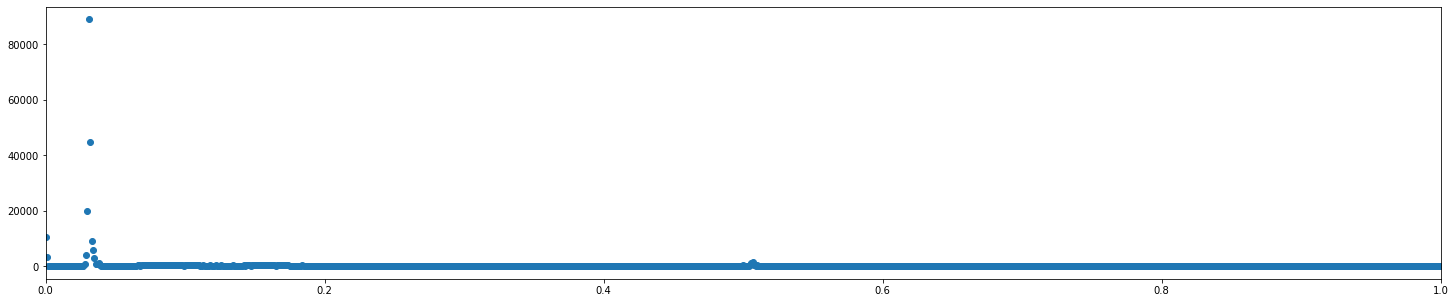

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


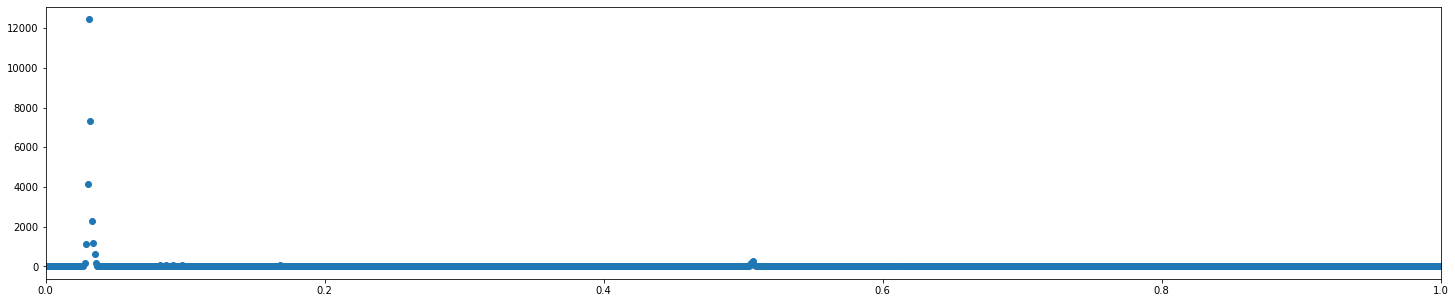

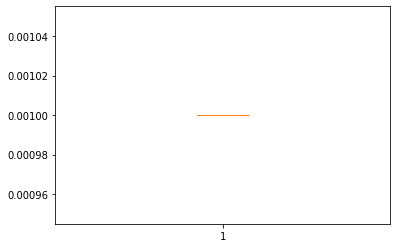

{'nobs': 367667, 'minmax': (0.001, 3066.985), 'mean': 0.8567961252981641, 'variance': 277.3993696807862, 'skewness': 110.61839596021059, 'kurtosis': 14880.254974478145, 'user': 'user1'}
user 2
absent+present


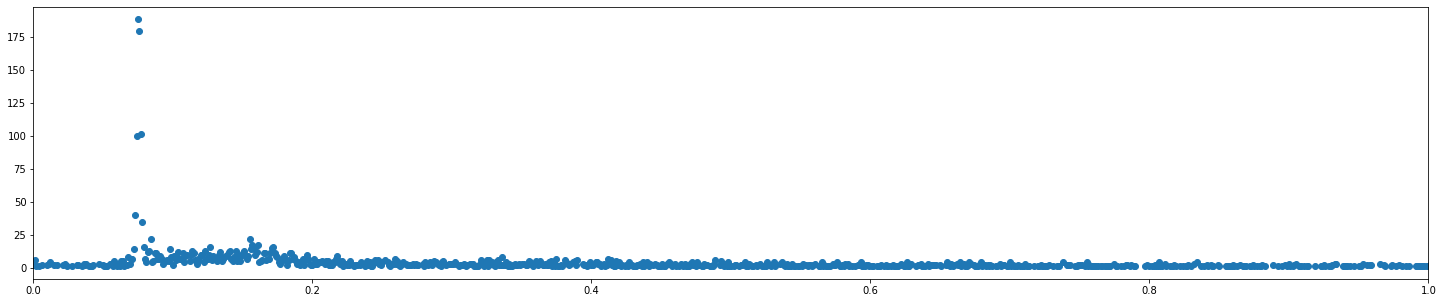

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


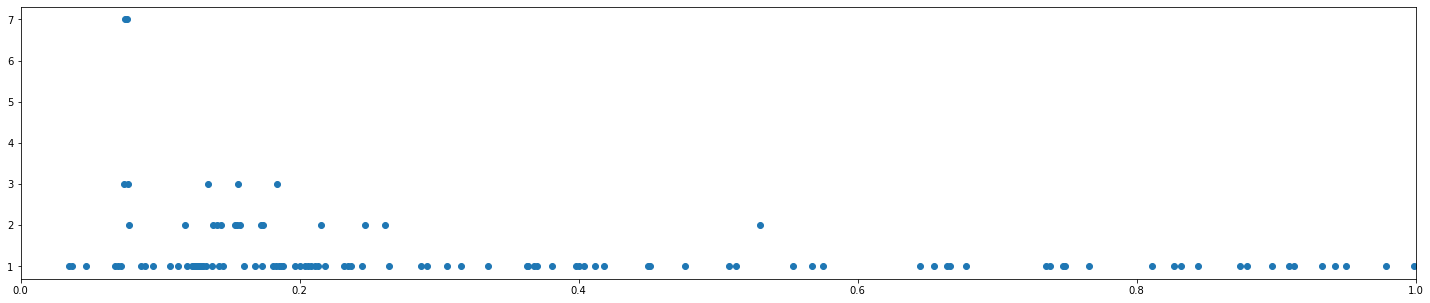

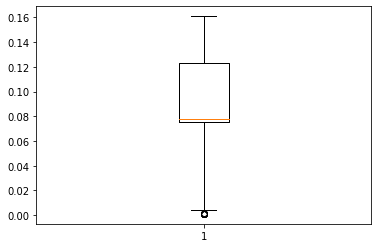

{'nobs': 3635, 'minmax': (0.001, 29.498), 'mean': 0.6614927097661623, 'variance': 2.3028699087938382, 'skewness': 8.910846155385835, 'kurtosis': 118.64463487153506, 'user': 'user2'}
user 3
absent+present


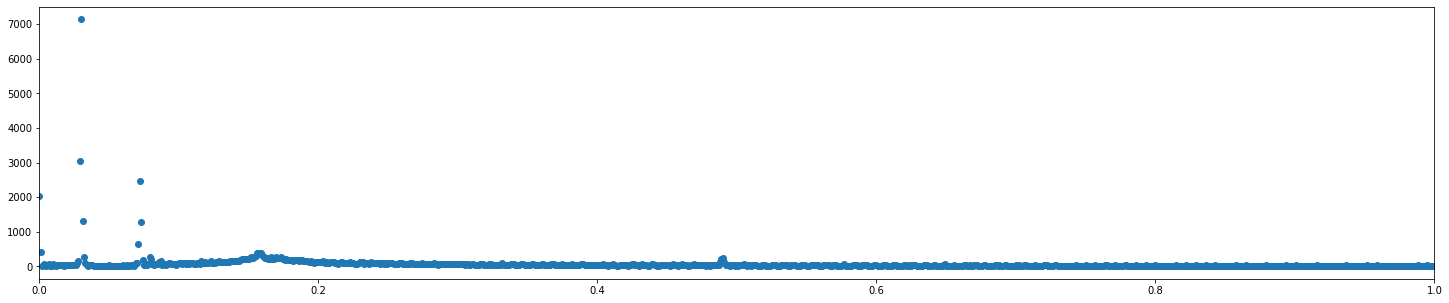

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


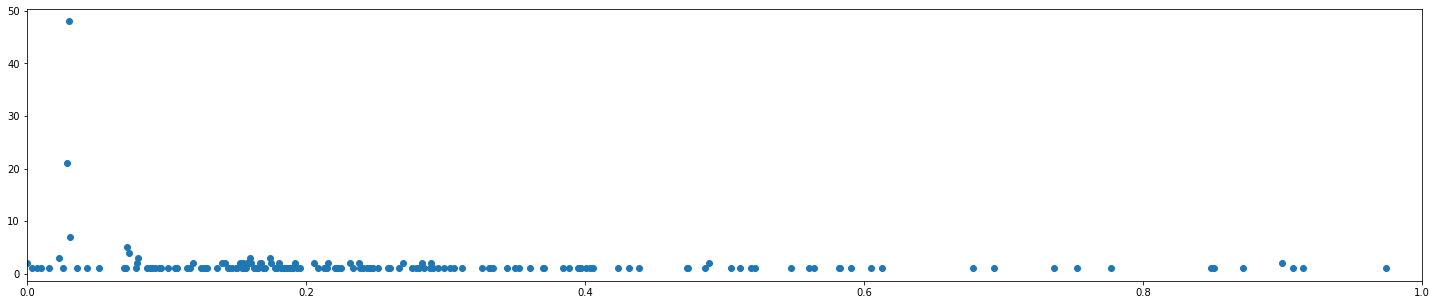

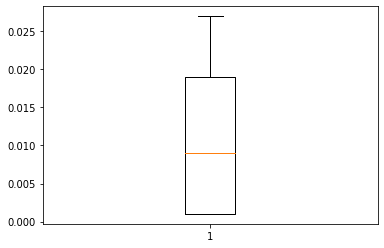

{'nobs': 84508, 'minmax': (0.001, 3109.492), 'mean': 0.9592256709423962, 'variance': 252.20481676104023, 'skewness': 162.04134118632422, 'kurtosis': 29359.018392274495, 'user': 'user3'}
user 4
absent+present


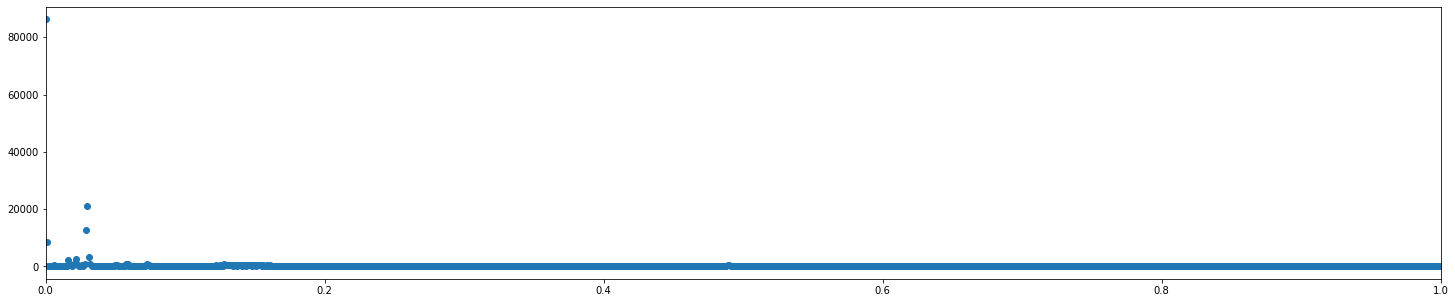

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


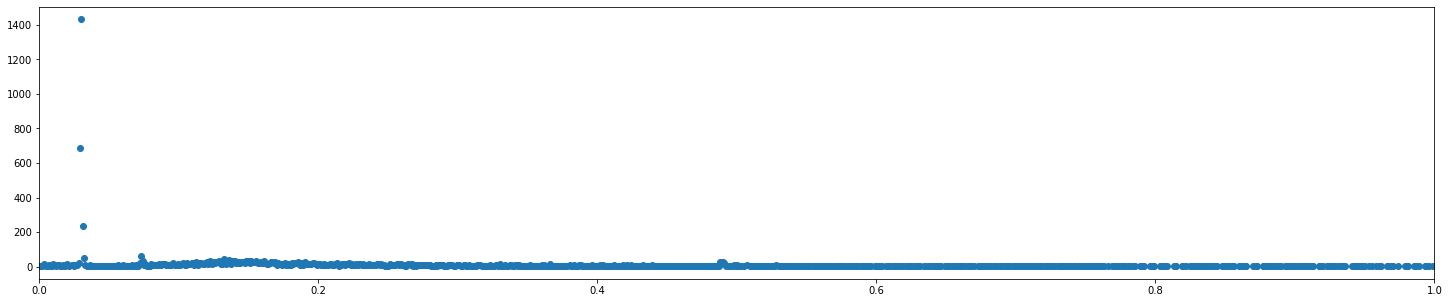

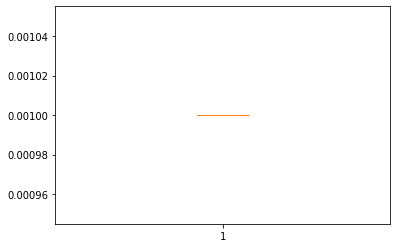

{'nobs': 175672, 'minmax': (0.001, 2697.892), 'mean': 0.5863719488592377, 'variance': 71.82577700965719, 'skewness': 244.011760097225, 'kurtosis': 70415.27697054412, 'user': 'user4'}
user 5
absent+present


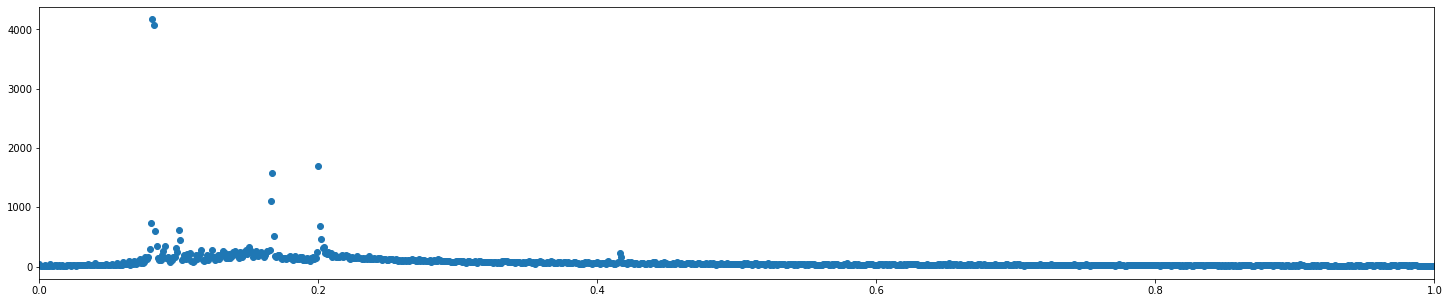

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


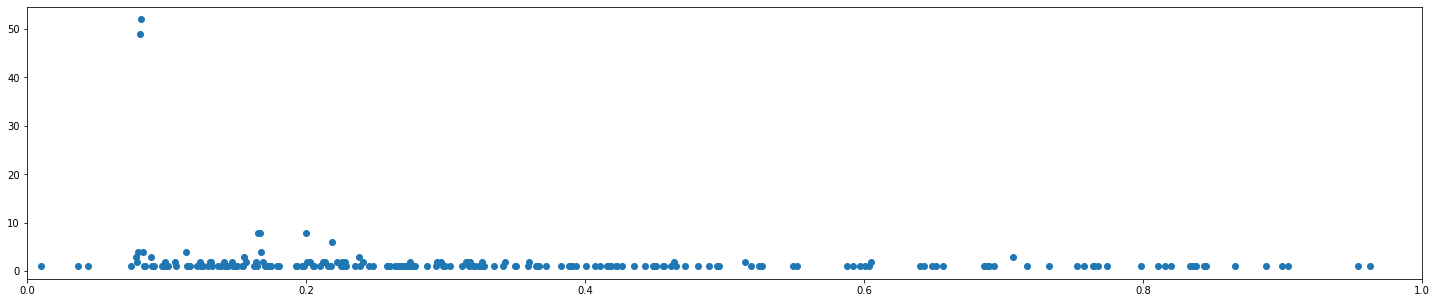

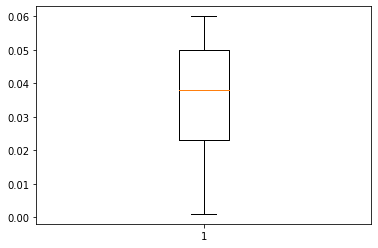

{'nobs': 90997, 'minmax': (0.001, 1497.38), 'mean': 0.7246434497840588, 'variance': 34.07190215808089, 'skewness': 191.08140379335757, 'kurtosis': 47726.751778542624, 'user': 'user5'}
user 7
absent+present


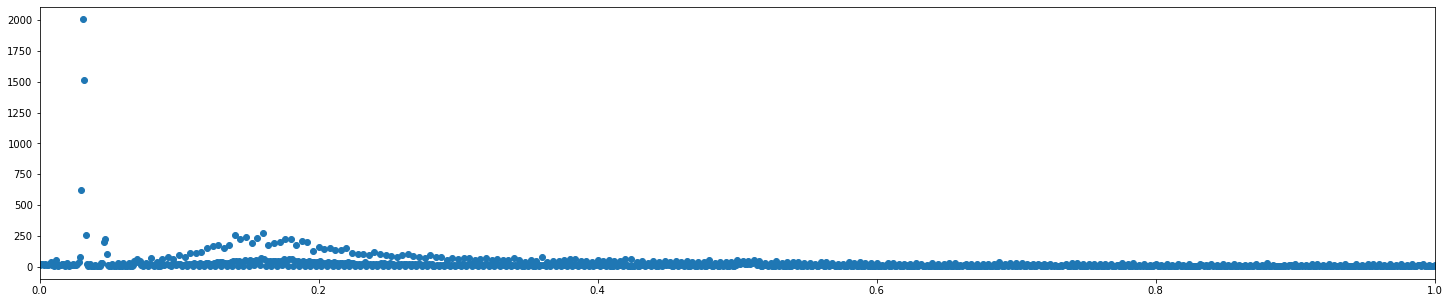

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


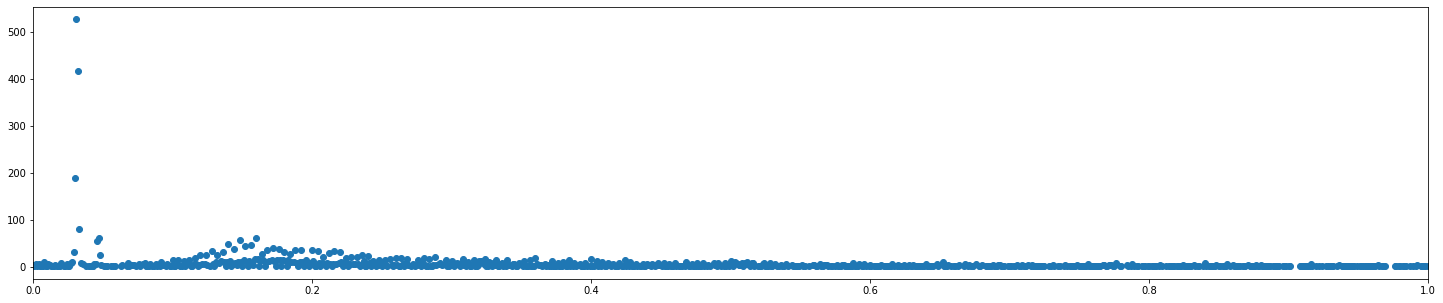

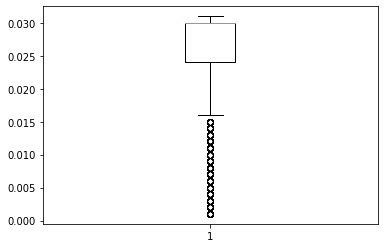

{'nobs': 31237, 'minmax': (0.001, 2609.346), 'mean': 1.279848480968083, 'variance': 663.9091864554955, 'skewness': 74.50766914450638, 'kurtosis': 6325.333194159578, 'user': 'user7'}
user 8
absent+present


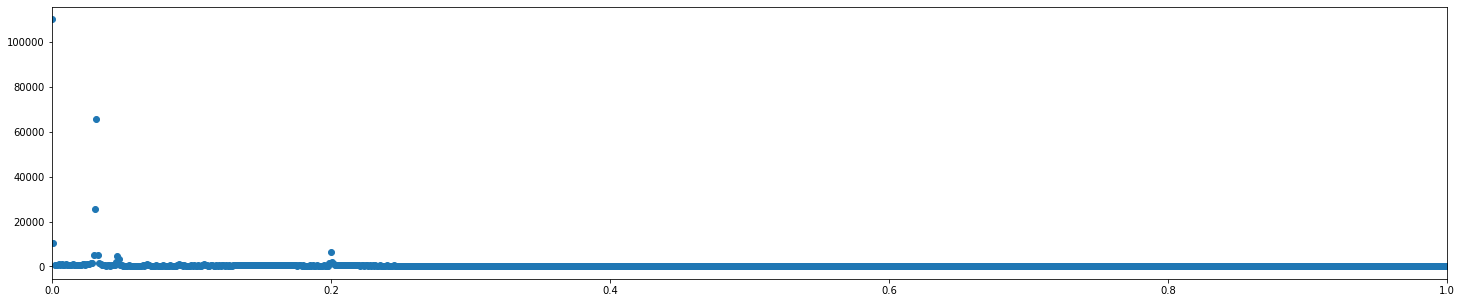

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


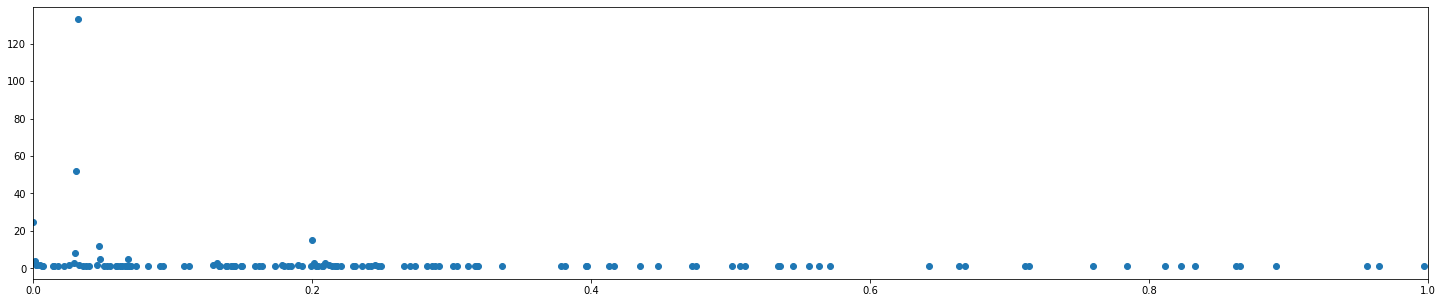

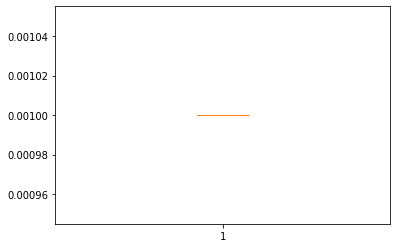

{'nobs': 345871, 'minmax': (0.001, 408.302), 'mean': 0.25774901046922116, 'variance': 3.3028324563552744, 'skewness': 97.8200034112633, 'kurtosis': 14600.845839349362, 'user': 'user8'}
user 10
absent+present


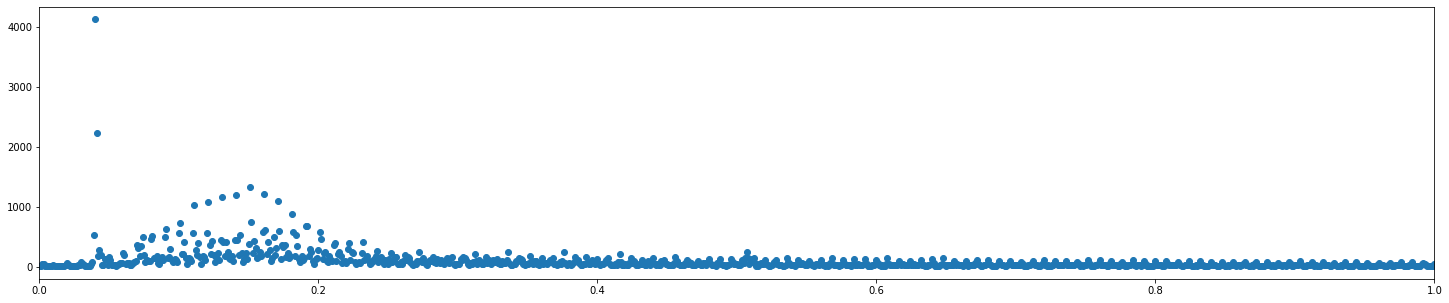

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


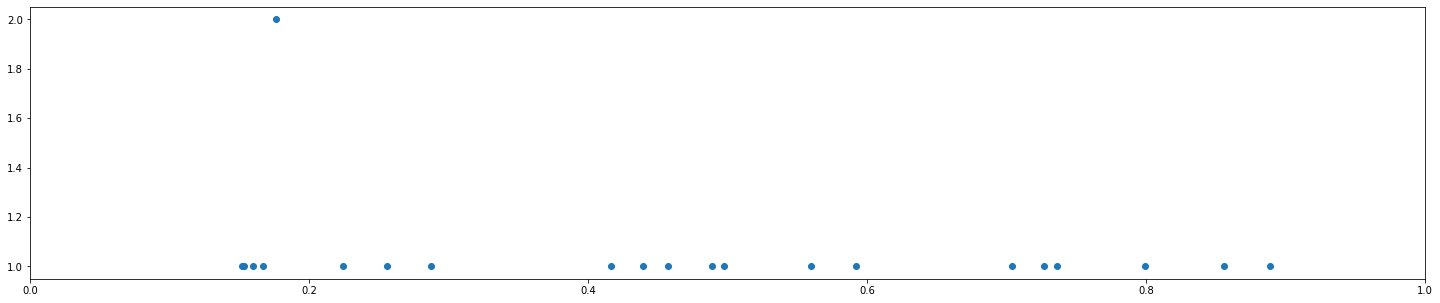

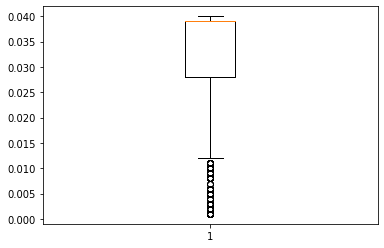

{'nobs': 115907, 'minmax': (0.001, 3239.82), 'mean': 1.4920675369045875, 'variance': 827.9603710710861, 'skewness': 81.8696210219305, 'kurtosis': 7758.52332508132, 'user': 'user10'}
user 11
absent+present


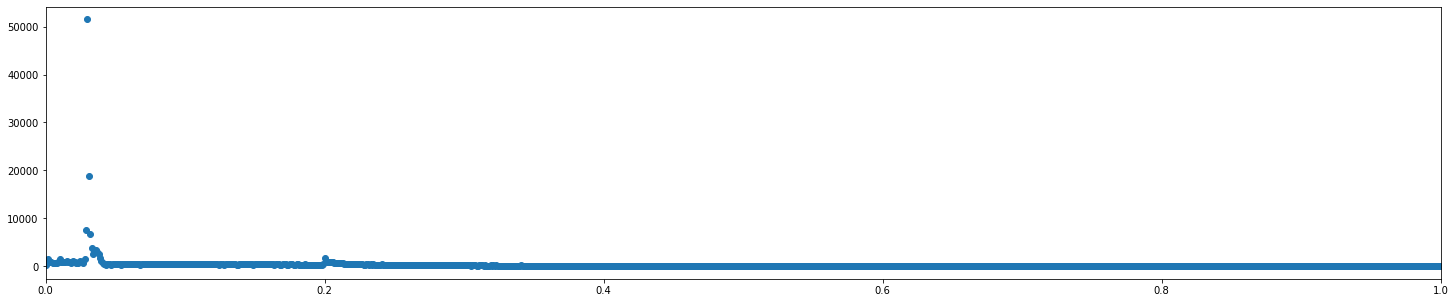

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


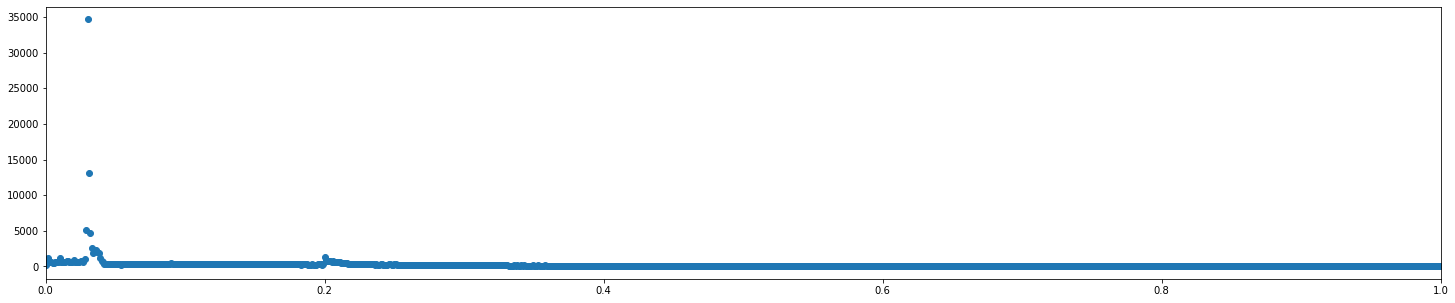

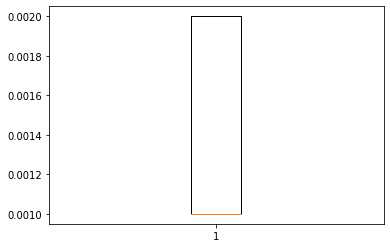

{'nobs': 292125, 'minmax': (0.001, 3577.058), 'mean': 0.3897605750962773, 'variance': 174.0592356149106, 'skewness': 166.40893231020755, 'kurtosis': 34907.32054717698, 'user': 'user11'}
user 13
absent+present


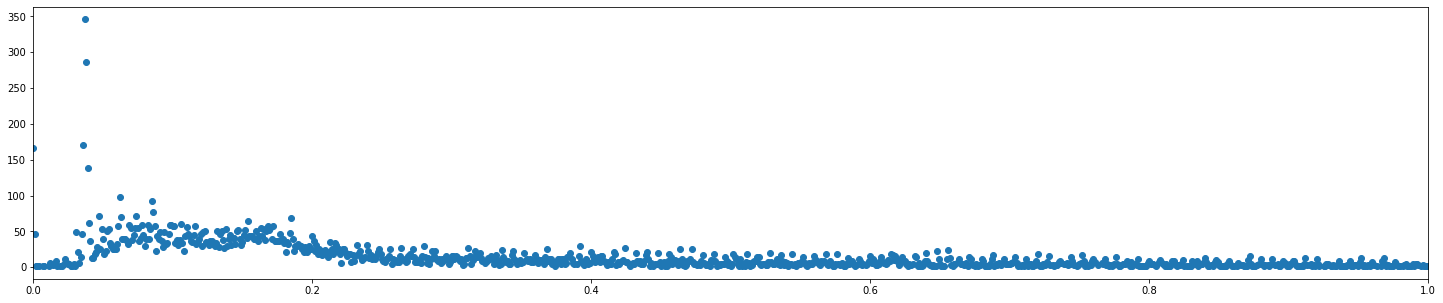

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


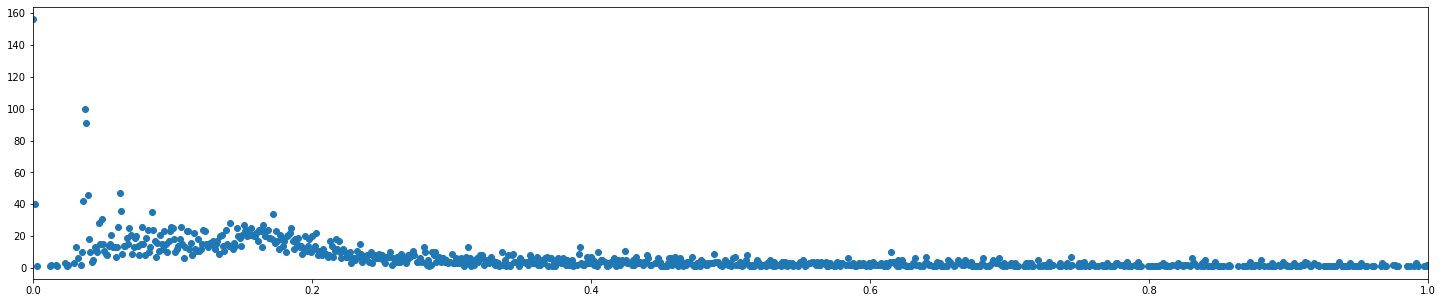

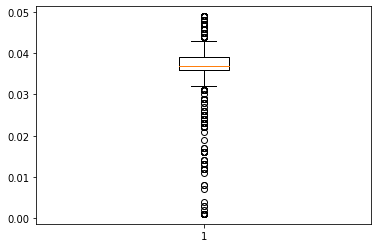

{'nobs': 16909, 'minmax': (0.001, 2632.029), 'mean': 2.610598556981489, 'variance': 1357.490626978058, 'skewness': 40.310139371242954, 'kurtosis': 2117.4752287771726, 'user': 'user13'}
user 14
absent+present


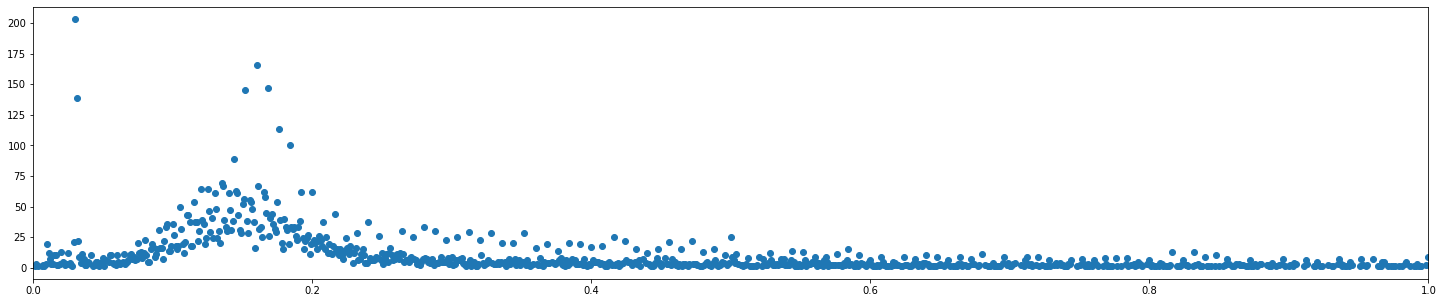

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


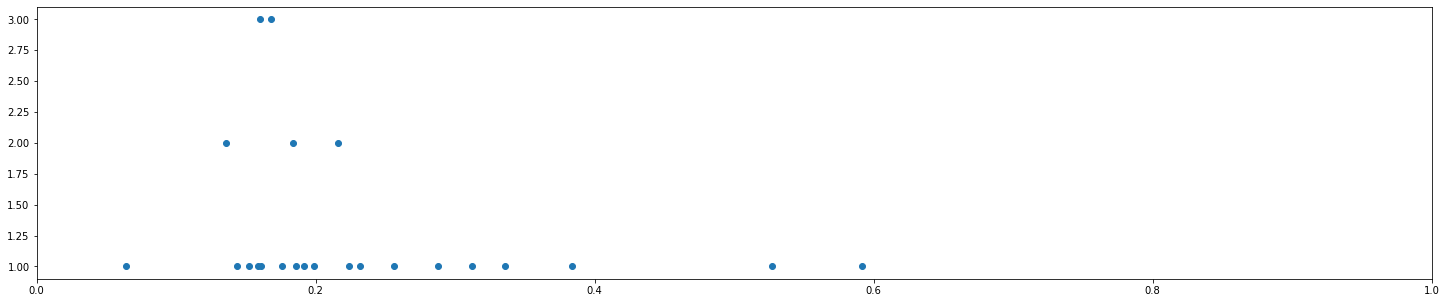

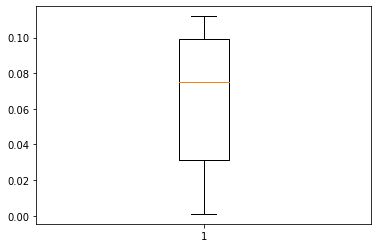

{'nobs': 9421, 'minmax': (0.001, 69.527), 'mean': 0.41514743657785796, 'variance': 1.815846888982016, 'skewness': 33.999704622118884, 'kurtosis': 1545.5990244036675, 'user': 'user14'}
user 15
absent+present


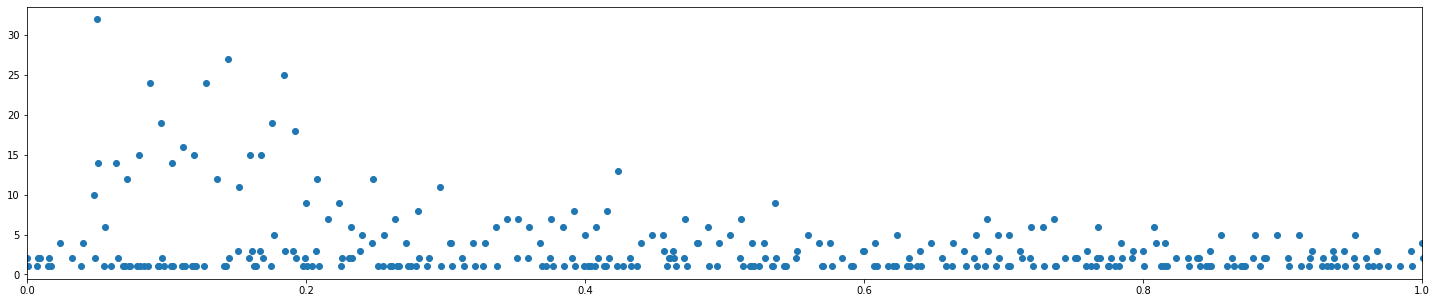

p = 3.41483e-171
The null hypothesis can be rejected
only present
<class 'dict_items'>


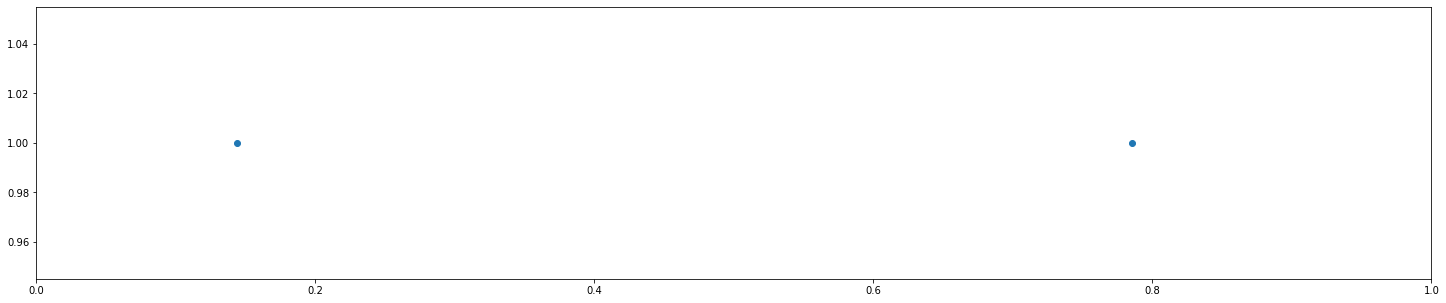

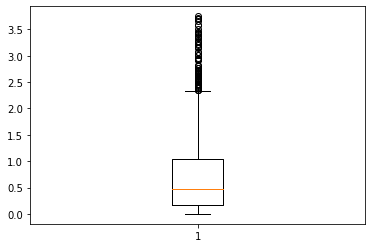

{'nobs': 1529, 'minmax': (0.001, 22.079), 'mean': 0.845018966644866, 'variance': 1.3664222345876746, 'skewness': 6.608697280100886, 'kurtosis': 87.1009825762522, 'user': 'user15'}
user 17
absent+present


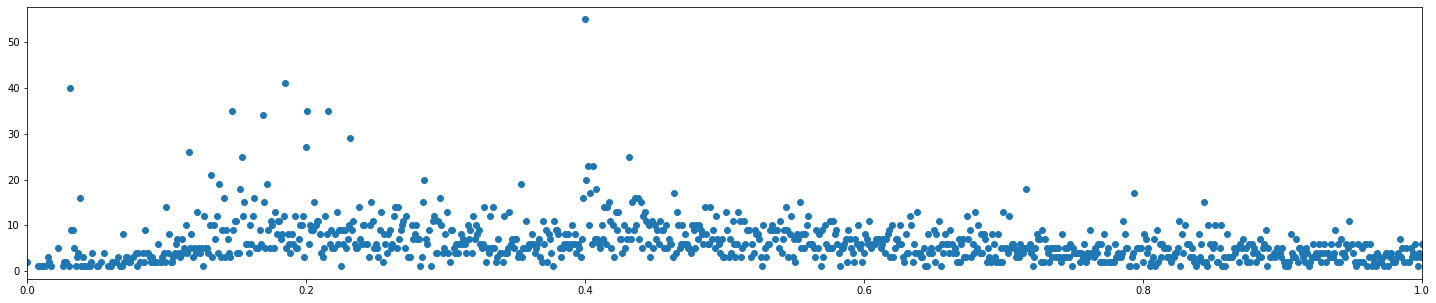

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


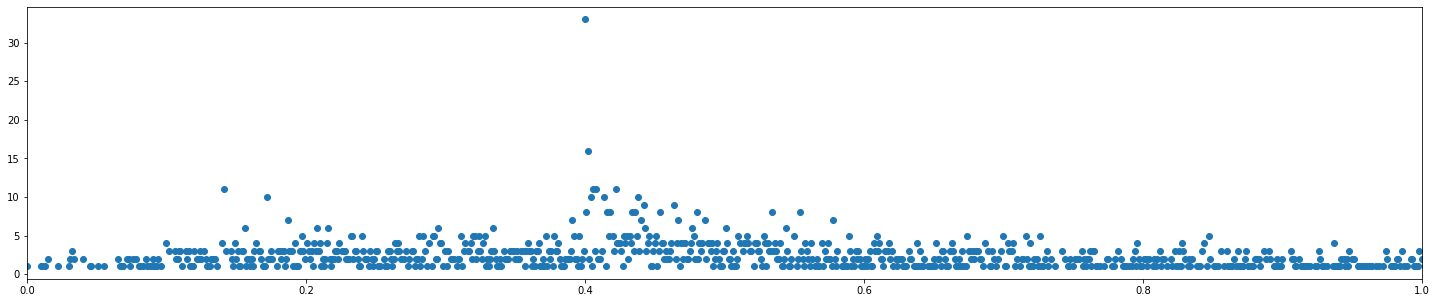

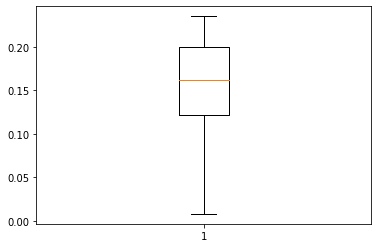

{'nobs': 8814, 'minmax': (0.008, 818.012), 'mean': 1.5719157022918084, 'variance': 179.70286725840995, 'skewness': 46.56766834502097, 'kurtosis': 2427.667699915817, 'user': 'user17'}
user 18
absent+present


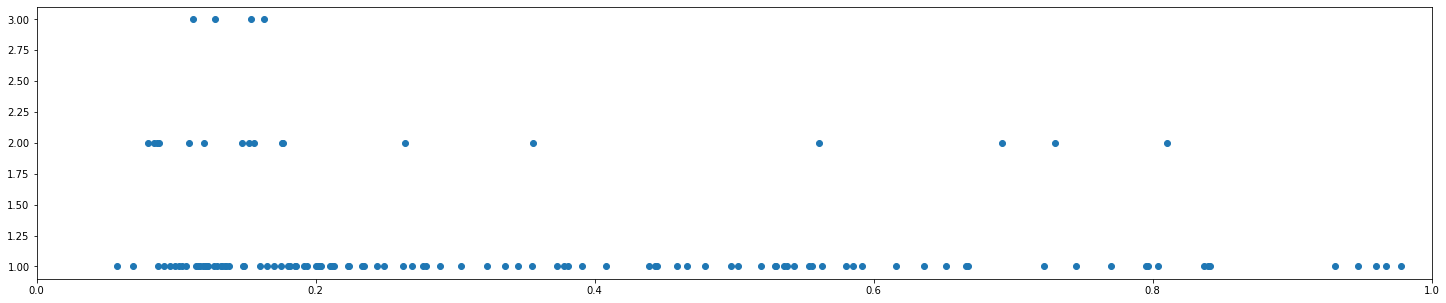

p = 7.9579e-70
The null hypothesis can be rejected
only present
<class 'dict_items'>


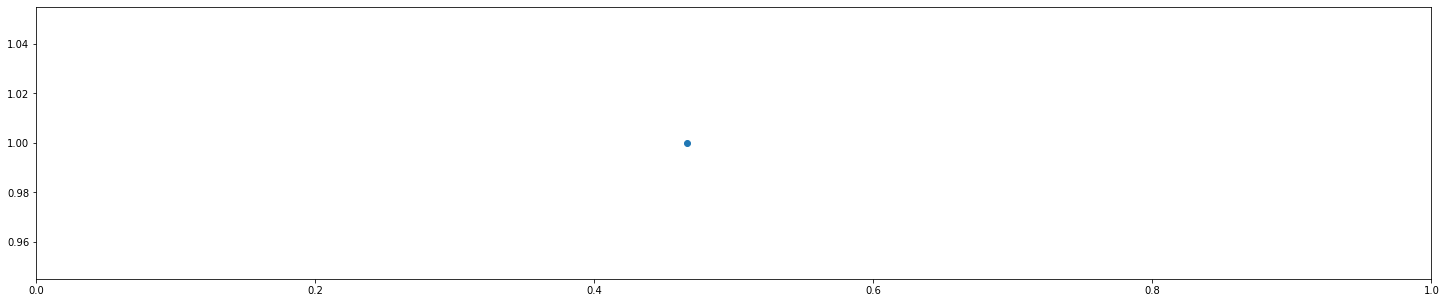

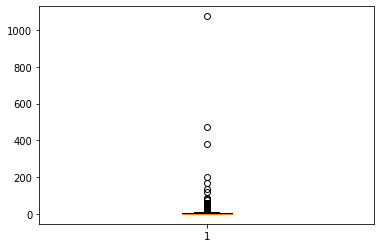

{'nobs': 349, 'minmax': (0.058, 1074.334), 'mean': 12.718458452722066, 'variance': 4675.551068047838, 'skewness': 12.228270785290317, 'kurtosis': 173.1127594219463, 'user': 'user18'}
user 19
absent+present


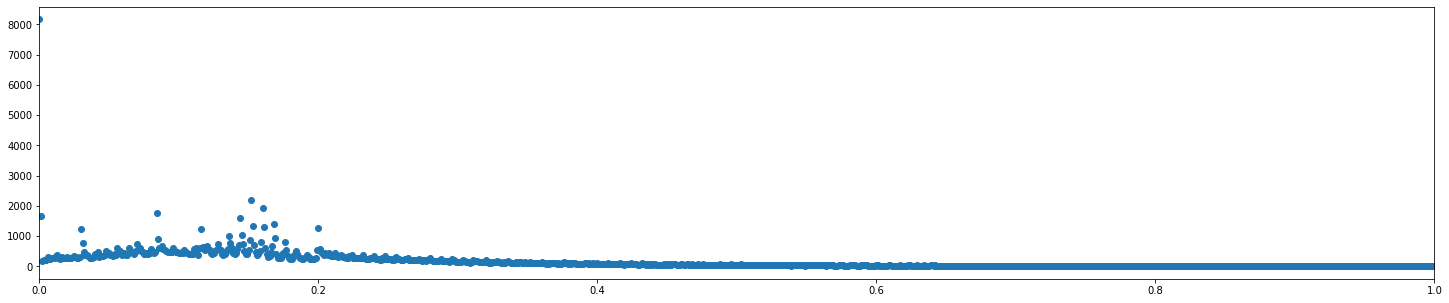

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


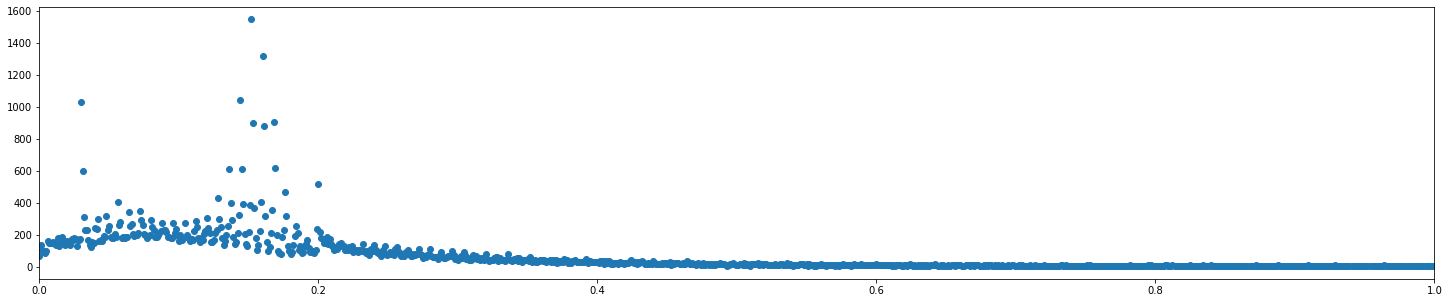

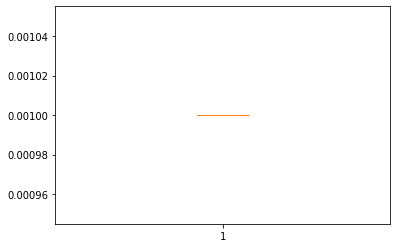

{'nobs': 165300, 'minmax': (0.001, 3057.865), 'mean': 0.5314145674531155, 'variance': 157.94241886679603, 'skewness': 152.00430421643873, 'kurtosis': 29741.207591342023, 'user': 'user19'}
user 20
absent+present


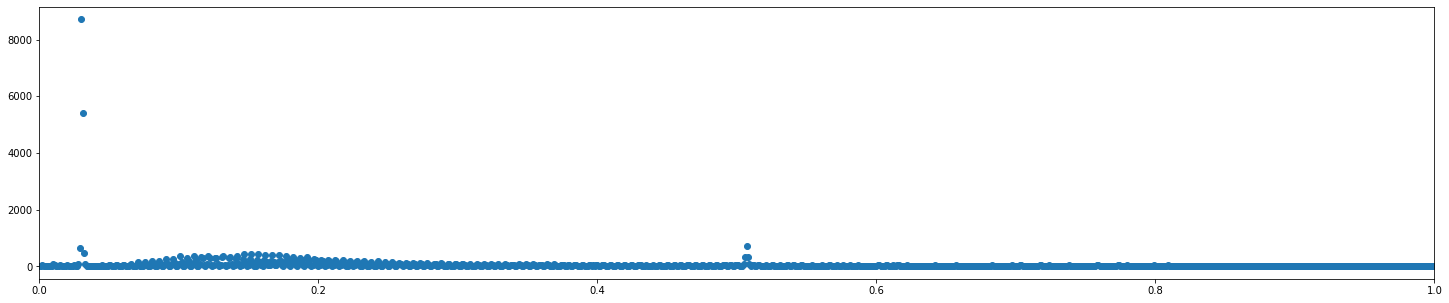

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


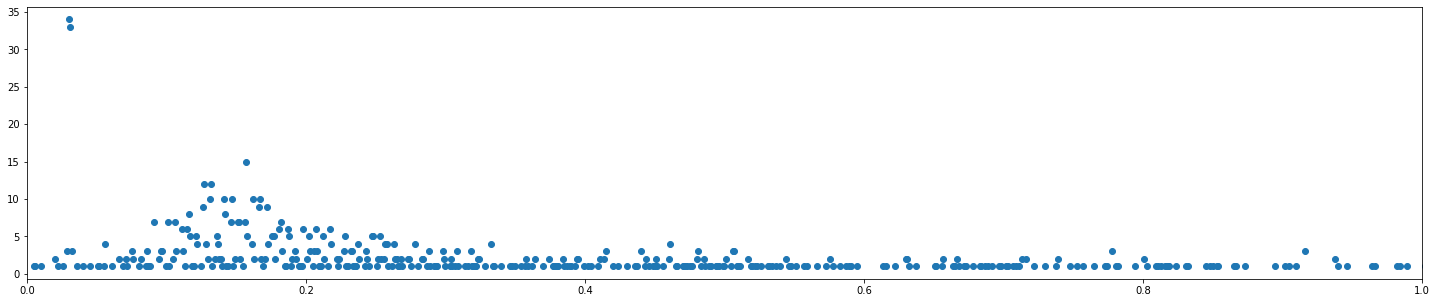

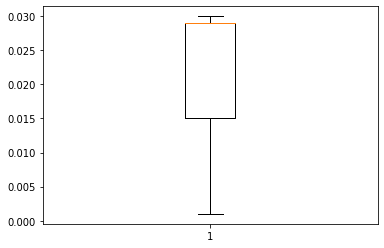

{'nobs': 77469, 'minmax': (0.001, 470.563), 'mean': 0.9530173230582556, 'variance': 23.67613574553044, 'skewness': 33.55752597591439, 'kurtosis': 1900.6953710851008, 'user': 'user20'}
user 21
absent+present


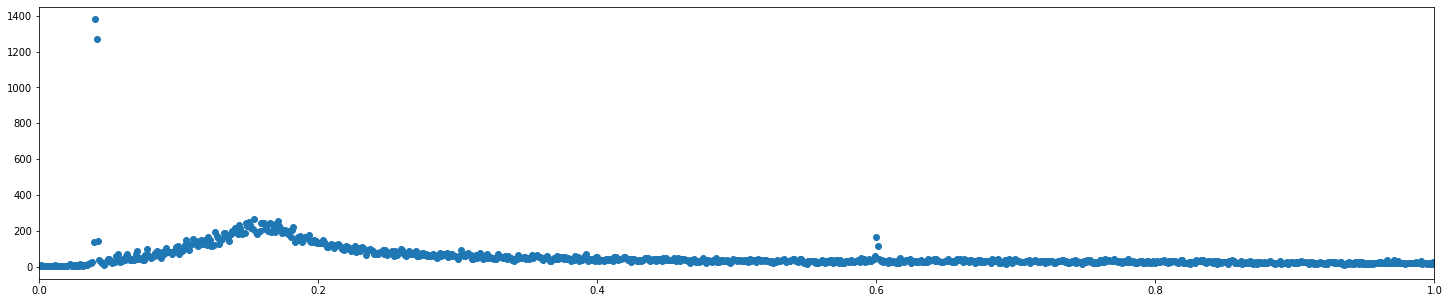

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


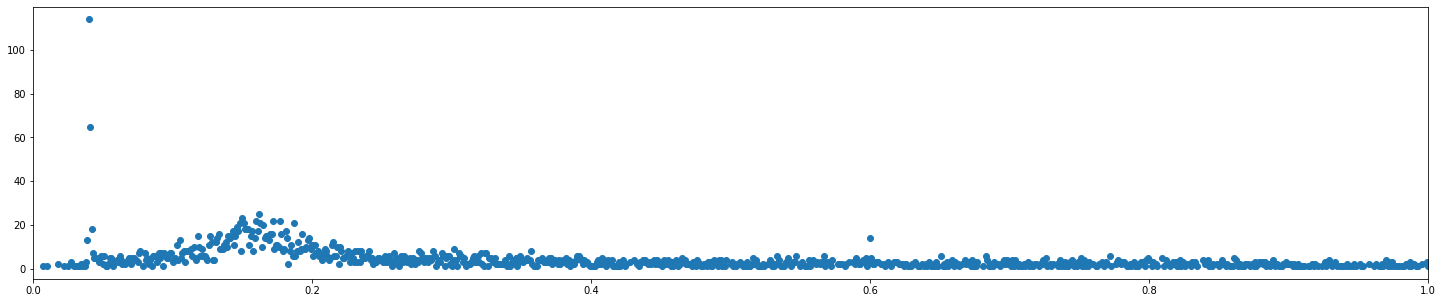

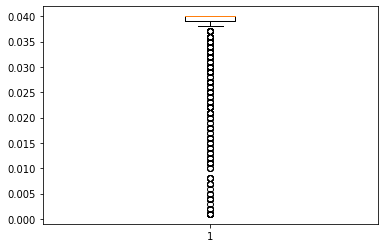

{'nobs': 75557, 'minmax': (0.001, 1960.211), 'mean': 1.3675050226980956, 'variance': 247.26668674349278, 'skewness': 83.78366262897521, 'kurtosis': 8333.874051526742, 'user': 'user21'}
user 22
absent+present


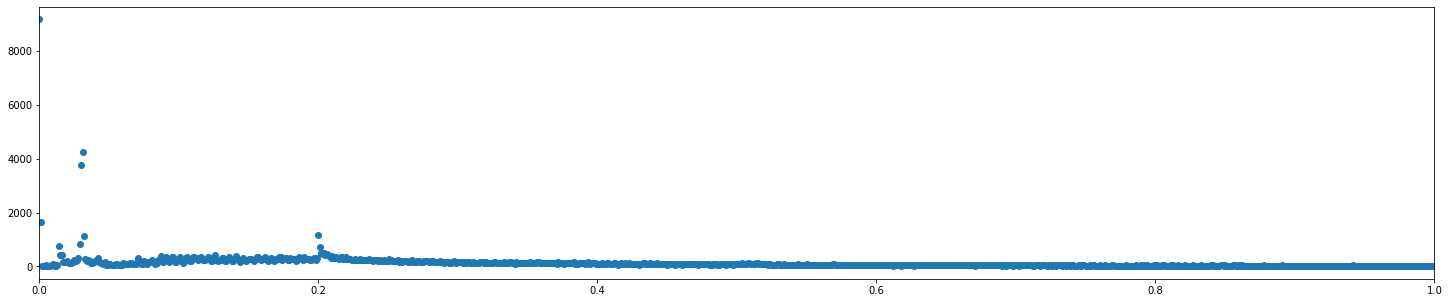

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


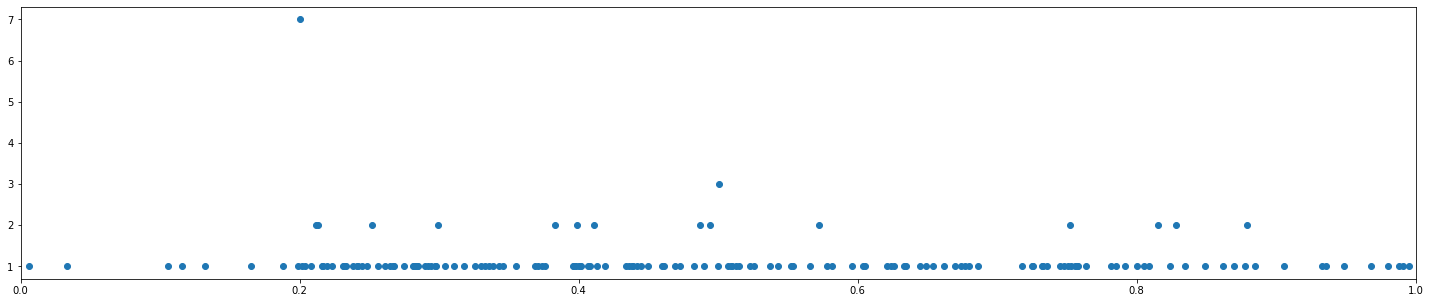

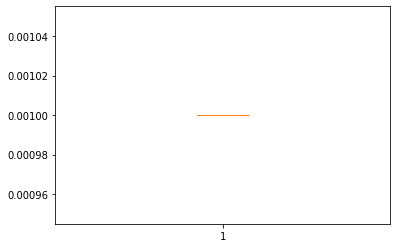

{'nobs': 140556, 'minmax': (0.001, 3195.133), 'mean': 0.7500794060730243, 'variance': 282.7498755461189, 'skewness': 144.3036537236807, 'kurtosis': 23805.10767476528, 'user': 'user22'}
user 23
absent+present


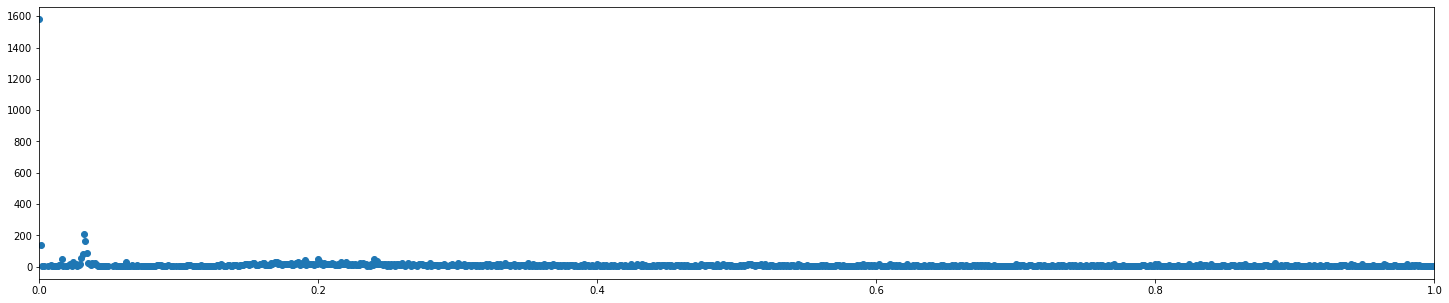

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


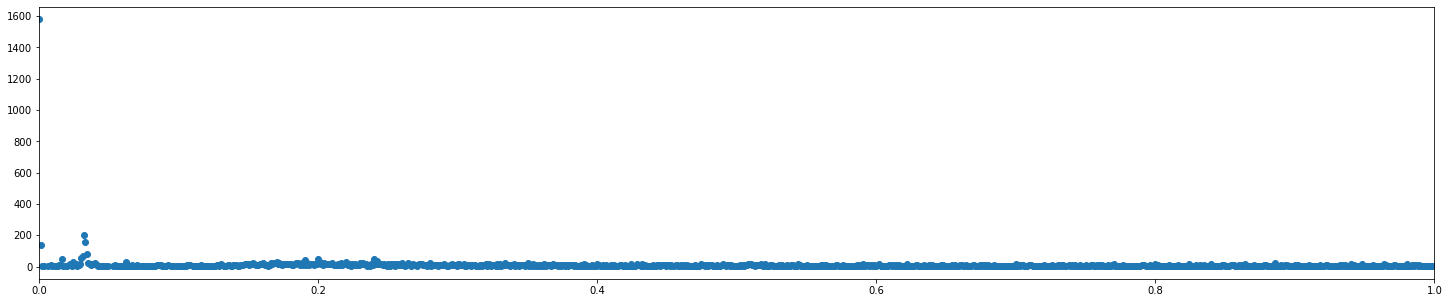

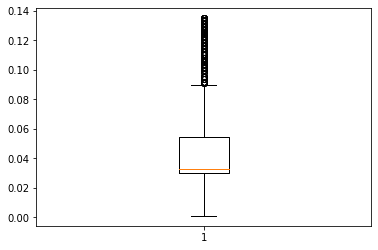

{'nobs': 15786, 'minmax': (0.001, 2988.626), 'mean': 4.80869187888002, 'variance': 3291.641209030935, 'skewness': 30.74323023373911, 'kurtosis': 1136.6203471288607, 'user': 'user23'}
user 25
absent+present


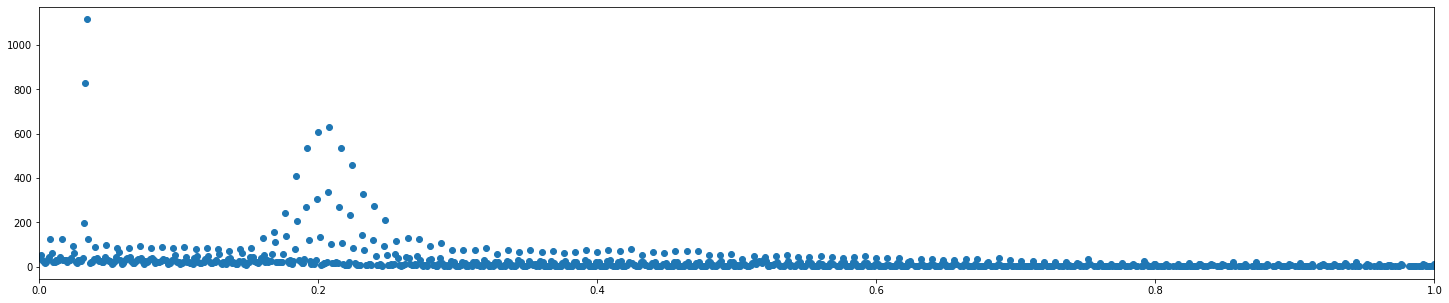

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


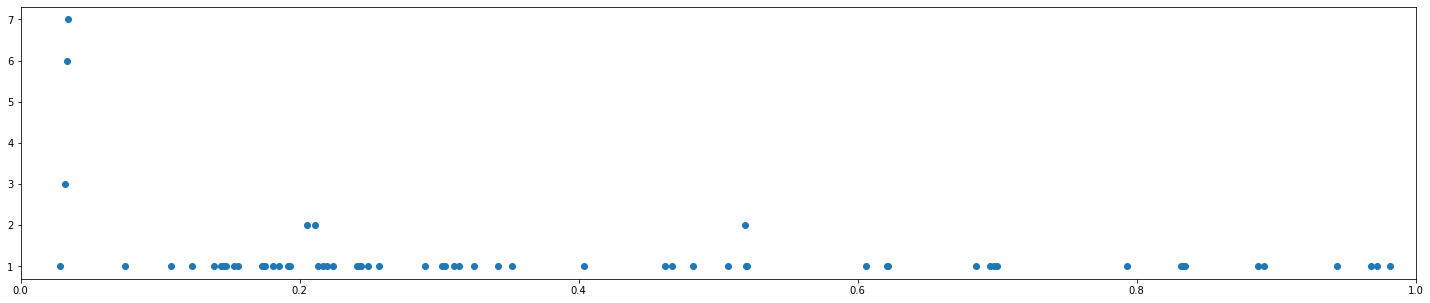

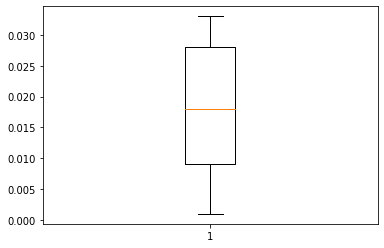

{'nobs': 26165, 'minmax': (0.001, 2528.188), 'mean': 0.9539707242499523, 'variance': 646.7786411583693, 'skewness': 72.82043222515182, 'kurtosis': 5932.358317909121, 'user': 'user25'}


In [36]:
descriptive_statistics = []
described_format = []

for i in range(1, 26):
    if i != 6 and i != 9 and i != 24 and i != 16 and i != 12:
        print("user", i)
        print("absent+present")
        #print(time_results['user'+str(i)][0].items())
        if i == 12:
            print(time_results['user'+str(i)][0].items())
        listed_gaps = sorted(time_results['user'+str(i)][0].items())
        x, y = zip(*listed_gaps) # plotting
        ticks = x[1::2]
        plt.figure(figsize=(25, 5))
        plt.xlim([0.0, 1.0])
        plt.scatter(x, y, marker='o')
        plt.show()
        k2, p = stats.normaltest(y)
        alpha = 1e-3
        print("p = {:g}".format(p))
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected")
        else:
            print("The null hypothesis cannot be rejected")
        print("only present")
        print(type(time_results['user'+str(i)][0].items()))
        listed_gaps = sorted(time_results['user'+str(i)][1].items())
        x2, y2 = zip(*listed_gaps) # plotting
        ticks = x[1::2]
        plt.figure(figsize=(25, 5))
        plt.xlim([0.0, 1.0])
        plt.scatter(x2, y2, marker='o')
        plt.show()
        describe_list = []
        for k, v in time_results['user'+str(i)][0].items():
            helper_list = [float(k)]*v
            describe_list.extend(helper_list)
        for_describe = sorted([item for item in describe_list if item > 0])
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.boxplot(for_describe[:1500])
        plt.show()
        described_format.append(for_describe)
        statistics = stats.describe(for_describe)._asdict()
        statistics["user"] = 'user'+str(i)
        print(statistics)
        descriptive_statistics.append(statistics)
# for i in range(3):
#     rec = get_data('signals'+str(i)+'.sqlite')
#     print("user",9)
#     print("absent+present")
#     listed_gaps = sorted(rec[0].items())
#     x, y = zip(*listed_gaps) # plotting
#     ticks = x[1::2]    if i != 6 and i != 9 and i != 16 and i != 24:

#     plt.figure(figsize=(25, 5))
#     plt.scatter(x, y, marker='o')
#     plt.show()
#     print("only present")
#     listed_gaps = sorted(rec[1].items())
#     x2, y2 = zip(*listed_gaps)
#     ticks = x2[1::2]
#     plt.figure(figsize=(25, 5))
#     plt.scatter(x2, y2, marker='o')
#     plt.show()

# Part 3
Compare users

In [20]:
sorted_by_mean = sorted(descriptive_statistics, key=lambda item: item['mean'])
print("SORTED BY MEAN")
for item in sorted_by_mean:
    print(item['user'], ":", item['mean'])

SORTED BY MEAN
user8 : 0.25774901046922116
user11 : 0.3897605750962773
user14 : 0.41514743657785796
user19 : 0.5314145674531155
user4 : 0.5863719488592377
user2 : 0.6614927097661623
user5 : 0.7246434497840588
user22 : 0.7500794060730243
user15 : 0.845018966644866
user1 : 0.8567961252981641
user20 : 0.9530173230582556
user25 : 0.9539707242499523
user3 : 0.9592256709423962
user7 : 1.279848480968083
user21 : 1.3675050226980956
user10 : 1.4920675369045875
user17 : 1.5719157022918084
user13 : 2.610598556981489
user23 : 4.80869187888002
user18 : 12.718458452722066


In [21]:
sorted_by_variance = sorted(descriptive_statistics, key=lambda item: item['variance'])
print("SORTED BY VARIANCE")
for item in sorted_by_variance:
    print(item['user'], ":", item['variance'])

SORTED BY VARIANCE
user15 : 1.3664222345876746
user14 : 1.815846888982016
user2 : 2.3028699087938382
user8 : 3.3028324563552744
user20 : 23.67613574553044
user5 : 34.07190215808089
user4 : 71.82577700965719
user19 : 157.94241886679603
user11 : 174.0592356149106
user17 : 179.70286725840995
user21 : 247.26668674349278
user3 : 252.20481676104023
user1 : 277.3993696807862
user22 : 282.7498755461189
user25 : 646.7786411583693
user7 : 663.9091864554955
user10 : 827.9603710710861
user13 : 1357.490626978058
user23 : 3291.641209030935
user18 : 4675.551068047838


In [22]:
sorted_by_max = sorted(descriptive_statistics, key=lambda item: item['minmax'][1])
print("SORTED BY MAX")
for item in sorted_by_max:
    print(item['user'], ":", item['minmax'])

SORTED BY MAX
user15 : (0.001, 22.079)
user2 : (0.001, 29.498)
user14 : (0.001, 69.527)
user8 : (0.001, 408.302)
user20 : (0.001, 470.563)
user17 : (0.008, 818.012)
user18 : (0.058, 1074.334)
user5 : (0.001, 1497.38)
user21 : (0.001, 1960.211)
user25 : (0.001, 2528.188)
user7 : (0.001, 2609.346)
user13 : (0.001, 2632.029)
user4 : (0.001, 2697.892)
user23 : (0.001, 2988.626)
user19 : (0.001, 3057.865)
user1 : (0.001, 3066.985)
user3 : (0.001, 3109.492)
user22 : (0.001, 3195.133)
user10 : (0.001, 3239.82)
user11 : (0.001, 3577.058)


In [23]:
score_repeats = 2000
stats.kruskal(described_format[0][:score_repeats], described_format[2][:score_repeats], described_format[3][:score_repeats], described_format[4][:score_repeats], described_format[5][:score_repeats], described_format[6][:score_repeats], described_format[7][:score_repeats], described_format[8][:score_repeats], described_format[9][:score_repeats], described_format[10][:score_repeats], nan_policy='omit')

KruskalResult(statistic=16722.855576226062, pvalue=0.0)

In [24]:
from scipy.stats import f_oneway
print(f_oneway(described_format[0][:score_repeats], described_format[1][:score_repeats], described_format[2][:score_repeats], described_format[3][:score_repeats], described_format[4][:score_repeats], described_format[5][:score_repeats], described_format[6][:score_repeats], described_format[7][:score_repeats], described_format[8][:score_repeats], described_format[9][:score_repeats], described_format[10][:score_repeats]))

F_onewayResult(statistic=6048.529072501278, pvalue=0.0)


In [25]:
test_tukey_data = []
for i in range(20):
    if i!= 13 and i!= 11:
        print (len(described_format[i][:score_repeats]))
        test_tukey_data.extend(described_format[i][:score_repeats])
df = pd.DataFrame({'score': test_tukey_data,
                   'group': np.repeat(['1', '2', '3','4', '5', '6','7', '8', '9', '10', '11', '12', '13','14', '15', '16','17', '18'], repeats=score_repeats )})
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['group'],
                          alpha=0.05)
print(tukey)
print(tukey.reject)
print(len(tukey.reject))
print(len([x for x in tukey.reject if x == True]))

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1     10   0.0403  0.001  0.0372  0.0433   True
     1     11   0.0788  0.001  0.0758  0.0819   True
     1     12   0.1813  0.001  0.1783  0.1844   True
     1     13   0.0003    0.9 -0.0028  0.0033  False
     1     14   0.0234  0.001  0.0203  0.0264   True
     1     15   0.0371  0.001   0.034  0.0401   True
     1     16   0.0011    0.9 -0.0019  0.0042  False
     1     17   0.0716  0.001  0.0686  0.0746   True
     1     18   0.0213  0.001  0.0183  0.0243   True
     1      2   0.1217  0.001  0.1186  0.1247   True
     1      3   0.0143  0.001  0.0113  0.0173   True
     1      4      0.0    0.9  -0.003   0.003  False
     1      5   0.0422  0.001  0.0391  0.0452   True
     1      6   0.0258  0.001  0.0227  0.0288   True
     1   

In [26]:
for i in range(11):
    print(len(described_format[i]))

367667
3635
84508
175672
90997
31237
345871
115907
292125
16909
9421


In [29]:
#print(time_results['user'+str(1)])
print(len(time_results['user'+str(1)]))

2
